In [1]:
from datetime import date
from glob import glob
import json
import os
from pathlib import Path
import pickle
import sys
import time

from matplotlib import animation
from matplotlib.colorbar import Colorbar
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import mplcursors
import numpy as np
import pandas as pd
from scipy import interpolate, signal, stats, fftpack, ndimage

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_evoked_traces, get_events_wdict, find_nearest_ind

In [4]:
%matplotlib widget

In [5]:
plotsavedir = r"C:\Users\lesliec\OneDrive - Allen Institute\data\plots\LFP_respiration"

Good respiration signals:
 - 703603 aw_iso
 - 703063 urethane
 - 720762 aw_iso
 - 720762 urethane
 - 709400 aw_iso, some good
 - 709400 urethane, artifact near end

# Load experiment

In [6]:
recfolder = r"P:\mouse703063\aw_iso_2023-11-16_11-16-30\experiment1\recording1"
exp = EEGexp(recfolder, preprocess=False, make_stim_csv=False)
exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print(exp_tag)

Experiment type: electrical and sensory stimulation
aw_iso


## Load all data

### Stim log

In [7]:
if exp.stimulus_log_file:
    stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})
else:
    print('No stim log found.')

In [8]:
stim_log.head()

,stim_type,parameter,onset,offset,duration,sweep
0,biphasic,25,760.48527,760.48567,0.0004,0
1,biphasic,25,767.07123,767.07163,0.0004,0
2,biphasic,35,773.83414,773.83454,0.0004,0
3,biphasic,15,781.13560,781.13600,0.0004,0
4,biphasic,15,787.66526,787.66566,0.0004,0


### Running

In [9]:
running_file = os.path.join(exp.data_folder, 'running_signal.npy')
running_ts_file = os.path.join(exp.data_folder, 'running_timestamps_master_clock.npy')

if os.path.exists(running_file) and os.path.exists(running_ts_file):
    speed = np.load(running_file)
    speedts = np.load(running_ts_file)
else:
    running_ts_file = os.path.join(exp.data_folder, 'running_timestamps.npy')
    speed = np.load(running_file)
    speedts = np.load(running_ts_file)

### Pupil

In [10]:
if len(glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)) > 0:
    pupil_file = glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)[0]
    pupildf = pd.read_csv(pupil_file)
  
    pupilts = pupildf.sync_time.values
    pupilD = pupildf.Largest_Radius.values
    ## smooth pupil diameter, then normalize ##
    sm_pupil = np.zeros_like(pupilD)
    k = 5 # filter window is actually k*2+1
    for i in range(k, len(pupilD)-k-1):
        sm_pupil[i] = np.mean(pupilD[i-k:i+k]) # each point is the average of k surrounding points
    sm_pupil[:k] = pupilD[:k]
    sm_pupil[-k-1:] = pupilD[-k-1:]
    pupil = sm_pupil / np.mean(pupildf.Eye_Diameter.values)
    print('{:d}% of frames do not have good pupil measurements'.format(int((np.sum(np.isnan(pupilD)) / len(pupilD)) * 100)))
else:
    print('No local Pupileye*.csv file. Check server.')

0% of frames do not have good pupil measurements


### Iso times

In [11]:
try:
    iso_induction, iso_maintenance = exp.load_iso_times()
    print(iso_induction[0])
    print(iso_induction[1])
    print(iso_maintenance[0])
except:
    iso_induction, iso_maintenance = None, None

3192.128140222819
3434.0979165030935
3434.107916483718


In [12]:
print(iso_induction)

(3192.128140222819, 3434.0979165030935)


### Respiration signal

In [13]:
respiration, respiration_ts = exp.load_analog_respiration()

In [14]:
freqs = [0.1, 25]
bpb, bpa = signal.butter(3, np.array(freqs)/(exp.ephys_params['EEG']['sample_rate']/2), btype='bandpass')
filt_resp = signal.filtfilt(bpb, bpa, respiration)

Text(0.5, 1.0, 'Raw respiration signal')

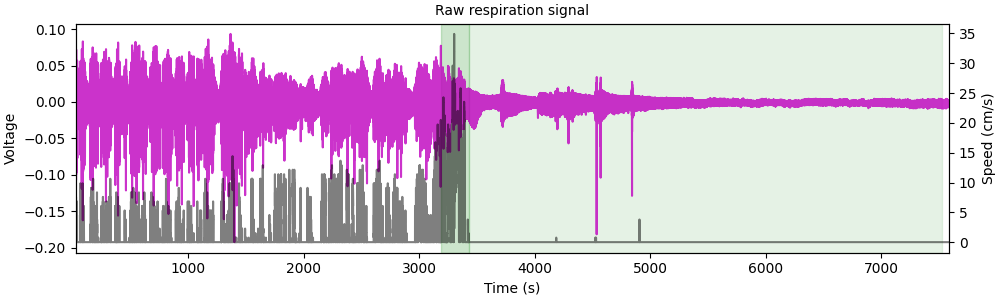

In [15]:
fig, ax = plt.subplots(figsize=(10,3), constrained_layout=True)
ax.plot(respiration_ts, filt_resp, color='m', alpha=0.8)
if iso_induction:
    ax.axvspan(iso_induction[0], iso_induction[1], color='g', alpha=0.2)
    ax.axvspan(iso_maintenance[0], iso_maintenance[1], color='g', alpha=0.1)
rax = ax.twinx()
## Speed ##
rax.plot(speedts, speed, color='k', alpha=0.5)
rax.set_ylabel('Speed (cm/s)')
## Pupil ##
# rax.plot(pupilts, sm_pupil, color='k', alpha=0.5)
# rax.set_ylabel('Pupil (pixels)')

ax.set_xlim([respiration_ts[0], respiration_ts[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage')
ax.set_title('Raw respiration signal')

### Load probe LFP

In [16]:
probe_list = [x.replace('_sorted', '') for x in exp.experiment_data if 'probe' in x]
print(probe_list)

['probeB', 'probeC', 'probeD', 'probeF']


In [17]:
for probei in probe_list:
    print(probei)
    with open(exp.ephys_params[probei]['probe_info']) as data_file:
        data = json.load(data_file)
    probe_areas = np.array(data['area_ch'])
    print(np.unique(probe_areas))
    print('')

probeB
['AMv' 'AV' 'CA1' 'CA2' 'CA3' 'LD' 'SSp-ll6a' 'SSp-ll6b' 'SSp-tr1'
 'SSp-tr2/3' 'SSp-tr4' 'SSp-tr5' 'SSp-tr6a' 'alv' 'ccb' 'cing' 'fi' 'null']

probeC
['CA1' 'DG-mo' 'DG-po' 'DG-sg' 'LP' 'PO' 'PoT' 'TH' 'VISp1' 'VISp2/3'
 'VISp4' 'VISp5' 'VISp6a' 'VISp6b' 'VPM' 'alv' 'bsc' 'fiber tracts' 'fp'
 'null' 'or']

probeD
['CP' 'GPe' 'SSp-bfd1' 'SSp-bfd2/3' 'SSp-bfd4' 'SSp-bfd5' 'SSp-bfd6a'
 'SSp-bfd6b' 'STR' 'ccb' 'fiber tracts' 'int' 'null' 'scwm']

probeF
['CP' 'LSr' 'LSv' 'MOs1' 'MOs2/3' 'MOs5' 'MOs6a' 'MOs6b' 'SEZ' 'STR' 'VL'
 'ccg' 'cing' 'fa' 'null']



In [18]:
probe_name = 'probeF'

## Load LFP as memmap ##
lfp_ts = np.load(exp.ephys_params[probe_name]['lfp_timestamps'])
lfp_data_mm = np.memmap(exp.ephys_params[probe_name]['lfp_continuous'], dtype='int16', mode='r').reshape(
    (len(lfp_ts), exp.ephys_params[probe_name]['num_chs']))

## Load probe_info.json ##
with open(exp.ephys_params[probe_name]['probe_info']) as data_file:
    data = json.load(data_file)
npx_allch = np.array(data['channel'])
surface_ch = int(data['surface_channel'])
allch_z = np.array(data['vertical_pos'])
ref_mask = np.array(data['mask'])
npx_chs = np.array([x for x in npx_allch if ref_mask[x] and x <= surface_ch])
probe_ch_depths = allch_z[surface_ch] - allch_z
probe_areas = np.array(data['area_ch'])

In [19]:
np.unique(probe_areas)

array(['CP', 'LSr', 'LSv', 'MOs1', 'MOs2/3', 'MOs5', 'MOs6a', 'MOs6b',
       'SEZ', 'STR', 'VL', 'ccg', 'cing', 'fa', 'null'], dtype='<U6')

In [20]:
area_chs = np.nonzero(probe_areas == 'null')[0]
print(area_chs)

[370 371 372 373 374 375 376 377 378 379 380 381 382 383]


In [21]:
plot_ch = 380
temp = lfp_data_mm[:, plot_ch]
lfpmv = temp * exp.ephys_params[probe_name]['bit_volts'] * 1E-3

Text(0.5, 1.0, 'LFP with thermistor signal (703063-aw_iso: probeF null)')

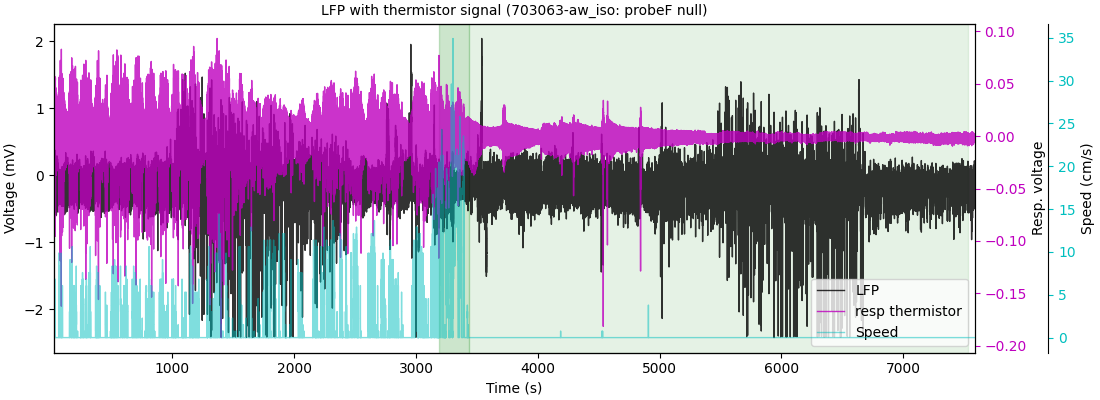

In [22]:
fig, ax = plt.subplots(figsize=(11,4), constrained_layout=True)
twin1 = ax.twinx()
twin2 = ax.twinx()
twin2.spines.right.set_position(("axes", 1.08))

lplot, = ax.plot(lfp_ts, lfpmv, color='k', linewidth=1.0, alpha=0.8, label='LFP')
if iso_induction:
    ax.axvspan(iso_induction[0], iso_induction[1], color='g', alpha=0.2)
    ax.axvspan(iso_maintenance[0], iso_maintenance[1], color='g', alpha=0.1)

rplot, = twin1.plot(respiration_ts, filt_resp, color='m', linewidth=1.0, alpha=0.8, label='resp thermistor')
# rplot, = twin1.plot(respiration_ts, respiration, color='m', linewidth=1.0, alpha=0.8, label='resp thermistor')
twin1.set_ylabel('Resp. voltage')
splot, = twin2.plot(speedts, speed, color='c', linewidth=1.0, alpha=0.5, label='Speed')
twin2.set_ylabel('Speed (cm/s)')
# splot, = twin2.plot(pupilts, sm_pupil, color='c', linewidth=1.0, alpha=0.5, label='Pupil')
# twin2.set_ylabel('Pupil (pixels)')

ax.tick_params(axis='y', colors=lplot.get_color())
twin1.tick_params(axis='y', colors=rplot.get_color())
twin2.tick_params(axis='y', colors=splot.get_color())

ax.set_xlim([lfp_ts[0], lfp_ts[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (mV)')
ax.legend(handles=[lplot, rplot, splot], loc='lower right')
ax.set_title('LFP with thermistor signal ({}-{}: {} {})'.format(exp.mouse, exp_tag, probe_name, probe_areas[plot_ch]))

Plot and save small chunks

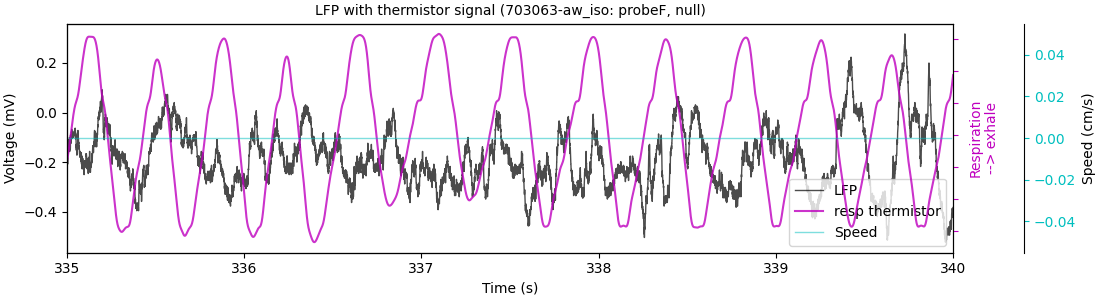

In [25]:
winstart = 335.
tag = 'awrest'
winlen = 5.

fig, ax = plt.subplots(figsize=(11,3), constrained_layout=True)
twin1 = ax.twinx()
twin2 = ax.twinx()
twin2.spines.right.set_position(("axes", 1.08))

lfpinds = np.nonzero((lfp_ts > winstart) & (lfp_ts < winstart + winlen))[0]
lplot, = ax.plot(lfp_ts[lfpinds], lfpmv[lfpinds], color='k', linewidth=1.0, alpha=0.7, label='LFP')
if iso_induction:
    ax.axvspan(iso_induction[0], iso_induction[1], color='g', alpha=0.2)
    ax.axvspan(iso_maintenance[0], iso_maintenance[1], color='g', alpha=0.1)

respinds = np.nonzero((respiration_ts > winstart) & (respiration_ts < winstart + winlen))[0]
rplot, = twin1.plot(respiration_ts[respinds], filt_resp[respinds], color='m', linewidth=1.5, alpha=0.8, label='resp thermistor')
twin1.set_yticklabels([])
twin1.set_ylabel('Respiration\n--> exhale', color=rplot.get_color())
## Choose speed or pupil ##
spinds = np.nonzero((speedts > winstart) & (speedts < winstart + winlen))[0]
splot, = twin2.plot(speedts[spinds], speed[spinds], color='c', linewidth=1.0, alpha=0.5, label='Speed')
twin2.set_ylabel('Speed (cm/s)')
# ppinds = np.nonzero((pupilts > winstart) & (pupilts < winstart + winlen))[0]
# splot, = twin2.plot(pupilts[ppinds], sm_pupil[ppinds], color='c', linewidth=1.0, alpha=0.5, label='Pupil')
# twin2.set_ylabel('Pupil (pixels)')
# twin2.set_ylim([10, 35])

ax.tick_params(axis='y', colors=lplot.get_color())
twin1.tick_params(axis='y', colors=rplot.get_color())
twin2.tick_params(axis='y', colors=splot.get_color())

ax.set_xlim([winstart, winstart + winlen])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (mV)')
ax.legend(handles=[lplot, rplot, splot], loc='lower right')
ax.set_title('LFP with thermistor signal ({}-{}: {}, {})'.format(exp.mouse, exp_tag, probe_name, probe_areas[plot_ch]))

## Save ##
fig_name = 'm{}{}_{}{:d}_LFPresp_{}{:d}.png'.format(exp.mouse, exp_tag, probe_name, plot_ch, tag, int(winstart))
fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)